In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import scipy.optimize as optimize
from tqdm import tqdm  
from scipy.stats import norm, wilcoxon
import seaborn as sns
from scipy.signal import savgol_filter
from pathlib import Path

In [ ]:
def analyze_option_overlap(base_path, all_hours, start_hour_for_cross_map):
    hourly_data = {}
    print("Loading all hourly data files...")
    for hour in all_hours:
        try:
            df = pd.read_csv(
                os.path.join(base_path, hour, f'btc_{hour}_0dte_data.csv'),
                parse_dates=['timestamp', 'expiry']
            )
            if 'symbol' not in df.columns or 'expiry' not in df.columns:
                print(f"Warning: 'symbol' or 'expiry' column not found for hour {hour}. Skipping.")
                continue
            hourly_data[hour] = df
        except FileNotFoundError:
            print(f"Warning: Data file not found for hour {hour}. Skipping.")

    if len(hourly_data) < 2:
        print("Not enough hourly data was loaded to perform a comparison. Exiting.")
        return

    def calculate_average_overlap(df1, df2):
        expiries1 = set(df1['expiry'].dt.date.unique())
        expiries2 = set(df2['expiry'].dt.date.unique())
        common_expiries = sorted(list(expiries1.intersection(expiries2)))
        
        avg_overlap = 0
        if common_expiries:
            daily_counts = [len(set(df1[df1['expiry'].dt.date == exp_day]['symbol'])
                              .intersection(set(df2[df2['expiry'].dt.date == exp_day]['symbol'])))
                          for exp_day in common_expiries]
            avg_overlap = np.mean(daily_counts)
        return avg_overlap

    cross_map_results = {}
    print(f"\nAnalyzing average overlap from start hour {start_hour_for_cross_map}:00 to all subsequent hours...")
    
    if start_hour_for_cross_map not in hourly_data:
        print(f"Error: Data for the cross-map start hour '{start_hour_for_cross_map}' was not found.")
    else:
        df_start = hourly_data[start_hour_for_cross_map]
        for end_hour in all_hours:
            if end_hour == start_hour_for_cross_map or end_hour not in hourly_data:
                continue
            
            df_end = hourly_data[end_hour]
            avg_overlap = calculate_average_overlap(df_start, df_end)
            interval_key = f"{start_hour_for_cross_map}:00 - {end_hour}:00"
            cross_map_results[interval_key] = avg_overlap

    consecutive_results = {}
    print("\nAnalyzing average overlap between consecutive hours...")
    for i in range(len(all_hours) - 1):
        hour_t0 = all_hours[i]
        hour_t1 = all_hours[i+1]
        
        if hour_t0 not in hourly_data or hour_t1 not in hourly_data:
            continue
            
        df_t0 = hourly_data[hour_t0]
        df_t1 = hourly_data[hour_t1]
        
        avg_overlap = calculate_average_overlap(df_t0, df_t1)
        interval_key = f"{hour_t0}:00 - {hour_t1}:00"
        consecutive_results[interval_key] = avg_overlap

    print("\n--- [Results] Average Common Contracts from Start Hour (Cross-Mapping) ---")
    if cross_map_results:
        for interval, avg_count in sorted(cross_map_results.items()):
            print(f"Interval: {interval} | Average Common Symbols: {avg_count:.2f}")
    else:
        print("No cross-mapping results to display.")
        
    print("\n--- [Results] Average Common Contracts Between Consecutive Hours ---")
    if consecutive_results:
        # Sort the results chronologically for readability
        sorted_keys = sorted(consecutive_results.keys(), key=lambda x: all_hours.index(x.split(':')[0]))
        for interval in sorted_keys:
            avg_count = consecutive_results[interval]
            print(f"Interval: {interval} | Average Common Symbols: {avg_count:.2f}")
    else:
        print("No consecutive overlap results to display.")


# Configuration 
base_file_path = '/Users/joris/Documents/Master QF/Thesis/optimal-gamma-hedging/Data/calibration_data'
trading_hours = ['08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '00', '01', '02', '03', '04', '05', '06', '07']
start_hour = '08'
analyze_option_overlap(base_file_path, trading_hours, start_hour)

Loading all hourly data files...

Analyzing average overlap from start hour 08:00 to all subsequent hours...

Analyzing average overlap between consecutive hours...

--- [Results] Average Common Contracts from Start Hour (Cross-Mapping) ---
Interval: 08:00 - 00:00 | Average Common Symbols: 9.12
Interval: 08:00 - 01:00 | Average Common Symbols: 9.53
Interval: 08:00 - 02:00 | Average Common Symbols: 8.38
Interval: 08:00 - 03:00 | Average Common Symbols: 9.56
Interval: 08:00 - 04:00 | Average Common Symbols: 10.16
Interval: 08:00 - 05:00 | Average Common Symbols: 9.86
Interval: 08:00 - 06:00 | Average Common Symbols: 11.21
Interval: 08:00 - 07:00 | Average Common Symbols: 11.00
Interval: 08:00 - 09:00 | Average Common Symbols: 8.59
Interval: 08:00 - 10:00 | Average Common Symbols: 8.29
Interval: 08:00 - 11:00 | Average Common Symbols: 10.07
Interval: 08:00 - 12:00 | Average Common Symbols: 9.14
Interval: 08:00 - 13:00 | Average Common Symbols: 9.77
Interval: 08:00 - 14:00 | Average Common

In [ ]:
# Initialize 
i = 1j    # imag unit
open_hour = '08'  

# Characteristic functions 
def chf_merton(u, r, tau, theta):
    sigma, xi, muJ, sigmaJ = theta
    omega_bar = xi * (np.exp(muJ + 0.5*sigmaJ**2) - 1)
    mu = r - 0.5*sigma**2 - omega_bar
    return np.exp(i*u*mu*tau-0.5*sigma**2*u**2*tau +
                  xi*tau*(np.exp(i*muJ*u - 0.5*sigmaJ**2*u**2) - 1))

def chf_kou(u, r, tau, theta):
    sigma, xi, alpha1, alpha2, p1 = theta
    p2 = 1 - p1
    omega_bar = xi * (1 - (p1*alpha1)/(alpha1-1) - (p2*alpha2)/(alpha2+1))
    mu = r - 0.5*sigma**2 + omega_bar
    return np.exp(i*u*mu*tau-0.5*sigma**2*u**2*tau + xi*tau*((p1*alpha1)/(alpha1 - i*u) + (p2*alpha2)/(alpha2 + i*u) - 1))

def chf_heston(u, r, tau, theta):
    v0, v_bar, gamma, rho = theta
    kappa = 0.5 # Fix kappa
    d = np.sqrt(np.power(kappa-gamma*rho*i*u,2)+(u**2+i*u)*gamma**2)
    g  = (kappa-gamma*rho*i*u-d)/(kappa-gamma*rho*i*u+d)
    C  = (1.0-np.exp(-d*tau))/(gamma*gamma*(1.0-g*np.exp(-d*tau)))\
        *(kappa-gamma*rho*i*u-d)
    A  = r * i*u *tau + kappa*v_bar*tau/gamma/gamma *(kappa-gamma*rho*i*u-d)\
        - 2*kappa*v_bar/gamma/gamma*np.log((1.0-g*np.exp(-d*tau))/(1.0-g))
    return np.exp(A + C*v0) 

def chf_bates(u, r, tau, theta):
    kappa, vbar, gamma, rho, v0, xi, muJ, sigmaJ = theta
    d = np.sqrt(np.power(kappa-gamma*rho*i*u,2)+((u**2)+i*u)*(gamma**2))
    g  = (kappa-gamma*rho*i*u-d)/(kappa-gamma*rho*i*u+d)
    C  = (1.0-np.exp(-d*tau))/((gamma**2)*(1.0-g*np.exp(-d*tau)))*(kappa-gamma*rho*i*u-d)
    AHes = r * i*u *tau + kappa*vbar*tau/gamma/gamma *(kappa-gamma*\
        rho*i*u-d) - 2*kappa*vbar/gamma/gamma*np.log((1.0-g*np.exp(-d*tau))/(1.0-g))
    A = AHes - xi * i * u * tau *(np.exp(muJ+0.5*sigmaJ**2) - 1.0) + \
            xi * tau * (np.exp(i*u*muJ - 0.5 * sigmaJ**2 * u**2) - 1.0)
    return np.exp(A + C*v0) 

# --- Cumulants
def merton_cumulants(tau, r, theta):
    sigma, xi, muJ, sigmaJ = theta
    omega_bar = xi * (np.exp(muJ + 0.5 * sigmaJ**2) - 1)
    c1 = tau * (r - omega_bar - 0.5 * sigma**2 - xi * muJ)
    c2 = tau * (sigma**2 + xi * (muJ**2 + sigmaJ**2))
    c4 = tau * xi * (muJ**4 + 6 * muJ**2 * sigmaJ**2 + 3 * sigmaJ**4 * xi)
    return c1, c2, c4

def kou_cumulants(tau, r, theta):
    sigma, xi, alpha1, alpha2, p1 = theta
    p2 = 1 - p1
    omega_bar = xi * (1 - (p1*alpha1)/(alpha1-1) - (p2*alpha2)/(alpha2+1))
    c1 = tau * (r + omega_bar - 0.5 * sigma**2 + ((xi * p1)/alpha1 - (xi * p2)/alpha2))
    c2 = tau * (sigma**2 + 2 * (xi * p1)/ alpha1**2 + 2 * (xi * p2)/alpha2**2)
    c4 = 24 * tau * xi * (p1 / alpha1**4 + p2 / alpha2**4) 
    return c1, c2, c4

# COS methods
def chi_psi_vec(k, a, b, c, d):
    omega = k * np.pi / (b - a)
    xi, psi = np.zeros_like(omega), np.zeros_like(omega)
    xi[0, :]  = np.exp(d) - np.exp(c)
    psi[0, :] = d - c
    if k.shape[0] > 1:
        omega_nz, k_nz = omega[1:, :], k[1:, :]
        denom = 1.0 + omega_nz**2
        xi[1:, :] = ( np.cos(omega_nz*(d-a))*np.exp(d) + omega_nz*np.sin(omega_nz*(d-a))*np.exp(d) - np.cos(omega_nz*(c-a))*np.exp(c) - omega_nz*np.sin(omega_nz*(c-a))*np.exp(c) ) / denom
        psi[1:, :] = ((b - a) / (k_nz * np.pi)) * (np.sin(omega_nz*(d - a)) - np.sin(omega_nz*(c - a)))
    return xi, psi

def payoff_coefficients_vec(CP, k, a, b):
    CP, is_call = np.asarray(CP, dtype=str), (CP == 'call')
    c = np.where(is_call, 0.0, a)
    d = np.where(is_call, b,   0.0)
    s = np.where(is_call, 1.0, -1.0)
    xi, psi = chi_psi_vec(k, a, b, c, d)
    H_k = (2.0 / (b - a)) * s * (xi - psi)
    return H_k

def delta_gamma(model, CP, S, K, tau, theta, N=512, L=10):
    r = 0.0
    S, tau, CP = np.asarray(S), np.asarray(tau), np.asarray(CP)
    x   = np.log(S / K)
    k = np.arange(N, dtype=float)[:, None]

    # Get the ChF for the model
    if model == 'merton':
        c1, c2, c4 = merton_cumulants(tau, r, theta)
        a = (x + c1 - L*np.sqrt(c2 + np.sqrt(c4)))[None, :]
        b = (x + c1 + L*np.sqrt(c2 + np.sqrt(c4)))[None, :]
        u = k * np.pi / (b - a)
        phi = chf_merton(u, r, tau, theta)

    elif model == 'kou':
        c1, c2, c4 = kou_cumulants(tau, r, theta)
        a = (x + c1 - L*np.sqrt(c2 + np.sqrt(c4)))[None, :]
        b = (x + c1 + L*np.sqrt(c2 + np.sqrt(c4)))[None, :]
        u = k * np.pi / (b - a)
        phi = chf_kou(u, r, tau, theta)

    elif model == 'heston':
        a = (0.0 - L*np.sqrt(tau))[None, :]
        b = (0.0 + L*np.sqrt(tau))[None, :]
        u = k * np.pi / (b - a)
        phi = chf_heston(u, r, tau, theta)
    
    elif model == 'bates':
        a = (0.0 - L*np.sqrt(tau))[None, :]
        b = (0.0 + L*np.sqrt(tau))[None, :]
        u = k * np.pi / (b - a)
        phi = chf_bates(u, r, tau, theta)

    H_k = payoff_coefficients_vec(CP[None, :], k, a, b)
    
    w0 = np.real(phi * np.exp(-1j * u * (a - x)))
    w1 = np.real(phi * (i*u) * np.exp(-i * u * (a - x)))
    w2 = np.real(phi * ((i*u)**2 - i*u) * np.exp(-i * u * (a - x)))

    w0[0, :] *= 0.5
    w1[0, :] *= 0.5
    w2[0, :] *= 0.5

    prices = np.exp(-r * tau) * K * np.sum(w0 * H_k, axis=0)
    delta = (S**-1) * np.exp(-r * tau) * K * np.sum(w1 * H_k, axis=0)
    gamma = (S**-2) *  np.exp(-r * tau) * K * np.sum(w2 * H_k, axis=0)
    return prices.astype(float), delta.astype(float), gamma.astype(float)

def bs_delta_gamma(opt_type, S, K, iv, tau, r=0.0):
    # iv in decimals, tau in years
    iv = np.maximum(iv, 1e-10)
    tau = np.maximum(tau, 1e-10)
    sqrt_tau = np.sqrt(tau)
    d1 = (np.log(S / K) + (r + 0.5 * iv**2) * tau) / (iv * sqrt_tau)
    call_delta = norm.cdf(d1)
    delta = np.where(opt_type == 'call', call_delta, call_delta - 1.0)
    gamma = norm.pdf(d1) / (S * iv * sqrt_tau)  # same for calls/puts
    return delta.reshape(-1), gamma.reshape(-1)

# Data processing functions
def filter_otm_calibration(df):
    df['moneyness'] = np.log(df['strike'] / df['spot'])
    mask =  ((df['opt_type'] == 'call') & (df['moneyness'] >= 0)) | \
            ((df['opt_type'] == 'put')  & (df['moneyness'] <= 0))
    df = df[mask]
    df = df.drop_duplicates(subset=['timestamp','strike'], keep='first')
    return df

def prep_side(df):
    out = df.copy()
    out = out.sort_values('timestamp').drop_duplicates('symbol', keep='last')
    out['opt_type'] = out['opt_type'].str.lower().str.strip()
    out['symbol'] = out['symbol'].str.strip()
    return out

if __name__ == "__main__":
    hours = ['09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '00', '01', '02', '03', '04', '05', '06', '07']
    for close_hour in hours:
        df_open = pd.read_csv(f'/Users/joris/Documents/Master QF/Thesis/optimal-gamma-hedging/Data/calibration_data/{open_hour}/btc_08_0dte_data.csv', parse_dates=['timestamp','expiry'])
        df_close = pd.read_csv(f'/Users/joris/Documents/Master QF/Thesis/optimal-gamma-hedging/Data/calibration_data/{close_hour}/btc_{close_hour}_0dte_data.csv', parse_dates=['timestamp','expiry'])

        df_open = filter_otm_calibration(df_open)
        df_close = filter_otm_calibration(df_close)
        
        cols_to_keep = ['timestamp','symbol','time_to_maturity','opt_type','strike','spot','mark_iv','bid_price','ask_price','mark_price','delta','gamma','vega','theta','rho','moneyness','moneyness_class']

        # Filter the columns to keep 
        df_open = df_open[cols_to_keep]
        df_close = df_close[cols_to_keep]

        # Parameter dictionary:
        params = {
            'merton': ['sigma', 'xi', 'muJ', 'sigmaJ'],
            'kou': ['sigma', 'xi', 'alpha1', 'alpha2', 'p1'],
            'heston': ['v0', 'v_bar', 'gamma', 'rho'],
            'bates': ['kappa', 'vbar', 'gamma', 'rho', 'v0', 'xi', 'muJ', 'sigmaJ']
        }

        for model in ['merton', 'kou', 'heston', 'bates']:
            params_df = pd.read_csv(f'/Users/joris/Documents/Master QF/Thesis/optimal-gamma-hedging/COS_Pricers/Hourly_Results/Calibration/{open_hour}/{model}_calibration_summary_{open_hour}.csv', parse_dates=['date'])
            params_df['date'] = params_df['date'].dt.date

            pnl_rows = []
            counter = 0
            # Merge dataframes based on symbol
            pnls = pd.DataFrame()
            for day in sorted(df_open['timestamp'].dt.date.unique()):
                df_open_day = prep_side(df_open[df_open['timestamp'].dt.date == day])
                if close_hour in ['00', '01', '02', '03', '04', '05', '06', '07']:
                    df_close_day = prep_side(df_close[df_close['timestamp'].dt.date == (day + pd.Timedelta(days=1))])
                else:
                    df_close_day = prep_side(df_close[df_close['timestamp'].dt.date == day])

                # Merge the dataframes on the keys
                open = df_open_day[['symbol','timestamp','spot','mark_price','mark_iv','time_to_maturity','opt_type',
                            'strike','delta','gamma','vega','theta','rho','moneyness','moneyness_class']].rename(
                        columns={'timestamp':'timestamp_open','spot':'spot_open','mark_price':'mark_price_open',
                            'time_to_maturity':'ttm_open', 'moneyness':'moneyness_open','moneyness_class':'moneyness_class_open'}
                        )
                close = df_close_day[['symbol','timestamp','spot','mark_price']].rename(
                        columns={'timestamp':'timestamp_close','spot':'spot_close','mark_price':'mark_price_close'}
                        )
                
                open_close_df = pd.merge(open, close, on='symbol', how='inner')

                open_close_df['moneyness_class_open'] = np.where(
                    np.abs(open_close_df['moneyness_open']) > 0.15, 'DOTM',
                    np.where(open_close_df['moneyness_open'] >= 0.05, 'OTM', 'ATM')
                )

                if open_close_df.empty:
                    counter += 1
                    continue

                # Extract the parameters for the day
                params_row = params_df.loc[params_df['date'] == day]
                if params_row.empty:
                    continue

                param_values = [params_row.iloc[0]['theta_' + p_name] for p_name in params[model]]            
                theta_open = np.array(param_values, dtype=float)
                
                # arrays for Greeks from the aligned frame
                CP_open   = open_close_df['opt_type'].values
                S_open    = open_close_df['spot_open'].values
                S_close    = open_close_df['spot_close'].values
                K         = open_close_df['strike'].values
                tau_open  = open_close_df['ttm_open'].values / (365*24*3600)  # years, as in extract_inputs

                prices_model, delta_model, gamma_model = delta_gamma(model, CP_open, S_open, K, tau_open, theta_open, N=512, L=10)

                # P&L Calculation in USD
                # Get option prices in USD and BTC from data
                price_btc_open  = open_close_df['mark_price_open'].values
                price_btc_close = open_close_df['mark_price_close'].values
                price_usd_open  = price_btc_open * S_open
                price_usd_close = price_btc_close * S_close

                # Calculate P&L of the option position in USD
                option_pnl_usd = price_usd_open - price_usd_close
                hedge_pnl_usd = delta_model * (S_open - S_close)
                pnl_delta_model = option_pnl_usd - hedge_pnl_usd
                
                # Find the ATM option to use as the gamma hedging instrument
                atm_idx = open_close_df['moneyness_open'].abs().idxmin()

                # Get characteristics of the ATM hedging option
                price_atm_open_usd = price_usd_open[atm_idx]
                price_atm_close_usd = price_usd_close[atm_idx]
                delta_atm_model = delta_model[atm_idx]
                gamma_atm_model = gamma_model[atm_idx]

                w_gamma = - (gamma_model / gamma_atm_model) # Add epsilon for stability

                # Calculate P&L of the delta gamma hedge in USD
                pnl_delta_gamma_model = price_usd_open + w_gamma * price_atm_open_usd - \
                                        (delta_model + w_gamma * delta_atm_model) * S_open    - \
                                        (price_usd_close + w_gamma * price_atm_close_usd) + \
                                        (delta_model + w_gamma * delta_atm_model) * S_close
                            
                
                # Stash result rows
                open_close_df = open_close_df[['symbol', 'strike', 'opt_type', 'timestamp_open', 'timestamp_close','spot_open', 'mark_price_open', 'moneyness_open', 'moneyness_class_open','mark_iv','delta','gamma','vega','theta','rho']].copy()
                open_close_df['mark_price_open'] = open_close_df['mark_price_open'] * open_close_df['spot_open']
                open_close_df[f'delta_{model}'] = delta_model
                open_close_df[f'gamma_{model}'] = gamma_model
                open_close_df[f'PnL_delta_{model}'] = pnl_delta_model
                open_close_df[f'PnL_delta_gamma_{model}'] = pnl_delta_gamma_model
                open_close_df[f'open_{model}'] = day
                pnl_rows.append(open_close_df)
            
            pnls = pd.concat(pnl_rows, ignore_index=True) if pnl_rows else pd.DataFrame()
            print(pnls.head())

            pnls.to_csv(f'/Users/joris/Documents/Master QF/Thesis/optimal-gamma-hedging/COS_Pricers/Hedging/{model}/{model}_hedge_results_{open_hour}_{close_hour}.csv', index=False)

            print(f"Missing days: {counter}")
        
        # Now for BS 
        bs_rows = []    
        counter_bs = 0
        pnls = pd.DataFrame()
        for day in sorted(df_open['timestamp'].dt.date.unique()):
            df_open_day = prep_side(df_open[df_open['timestamp'].dt.date == day])
            if close_hour in ['00', '01', '02', '03', '04', '05', '06', '07']:
                df_close_day = prep_side(df_close[df_close['timestamp'].dt.date == (day + pd.Timedelta(days=1))])
            else:
                df_close_day = prep_side(df_close[df_close['timestamp'].dt.date == day])

            # Merge the dataframes on the keys
            open = df_open_day[['symbol','timestamp','spot','mark_price','mark_iv', 'time_to_maturity','opt_type',
                        'strike','delta','gamma','vega','theta','rho','moneyness','moneyness_class']].rename(
                    columns={'timestamp':'timestamp_open','spot':'spot_open','mark_price':'mark_price_open',
                        'time_to_maturity':'ttm_open', 'moneyness':'moneyness_open','moneyness_class':'moneyness_class_open'}
                    )
            close = df_close_day[['symbol','timestamp','spot','mark_price']].rename(
                    columns={'timestamp':'timestamp_close','spot':'spot_close','mark_price':'mark_price_close'}
                    )
            
            open_close_df = pd.merge(open, close, on='symbol', how='inner')
            open_close_df['moneyness_class_open'] = np.where(
                np.abs(open_close_df['moneyness_open']) > 0.15, 'DOTM',
                np.where(open_close_df['moneyness_open'] >= 0.05, 'OTM', 'ATM')
                )
            if open_close_df.empty:
                counter_bs += 1
                continue
            
            # arrays for Greeks from the aligned frame
            CP_open   = open_close_df['opt_type'].values
            S_open    = open_close_df['spot_open'].values
            S_close    = open_close_df['spot_close'].values
            K         = open_close_df['strike'].values
            tau_open  = open_close_df['ttm_open'].values / (365*24*3600)  # years, as in extract_inputs
            iv_open  = (open_close_df['mark_iv'].values) / 100.0

            delta_bs, gamma_bs = bs_delta_gamma(
                open_close_df['opt_type'].values,
                open_close_df['spot_open'].values,
                open_close_df['strike'].values,
                iv_open, tau_open, r=0.0
            )
            
            # P&L Calculation in USD
            # Get option prices in BTC and USD from data
            price_btc_open  = open_close_df['mark_price_open'].values
            price_btc_close = open_close_df['mark_price_close'].values
            price_usd_open  = price_btc_open * S_open
            price_usd_close = price_btc_close * S_close
            
            # Calculate P&L of the delta hedge in USD 
            option_pnl_usd = price_usd_open - price_usd_close
            hedge_pnl_usd_bs = delta_bs * (S_open - S_close)
            pnl_delta_bs = option_pnl_usd - hedge_pnl_usd_bs
            
            # Find the ATM option to use as the gamma hedging instrument
            atm_idx = open_close_df['moneyness_open'].abs().idxmin()

            # Get characteristics of the ATM hedging option
            price_atm_open_usd = price_usd_open[atm_idx]
            price_atm_close_usd = price_usd_close[atm_idx]

            delta_atm_bs = delta_bs[atm_idx]
            gamma_atm_bs = gamma_bs[atm_idx]
            w_gamma_bs = - (gamma_bs / gamma_atm_bs) 

            # Calculate P&L of the delta gamma hedge in USD
            pnl_delta_gamma_bs =  price_usd_open + w_gamma_bs * price_atm_open_usd - \
                                    (delta_bs + w_gamma_bs * delta_atm_bs) * S_open    - \
                                    (price_usd_close + w_gamma_bs * price_atm_close_usd) + \
                                    (delta_bs + w_gamma_bs * delta_atm_bs) * S_close
            
            # Stash result rows
            out = open_close_df[['symbol','strike','opt_type','timestamp_open','timestamp_close', 'mark_price_open',
                                'spot_open','moneyness_open','moneyness_class_open','delta','gamma','vega','theta','rho']].copy()
            out['mark_price_open'] = out['mark_price_open'] * out['spot_open']
            out['delta_bs'] = delta_bs
            out['gamma_bs'] = gamma_bs
            out['PnL_delta_bs'] = pnl_delta_bs
            out['PnL_delta_gamma_bs'] = pnl_delta_gamma_bs
            out['open_bs'] = day
            bs_rows.append(out)

        bs_pnls = pd.concat(bs_rows, ignore_index=True) if bs_rows else pd.DataFrame()    
        bs_pnls.to_csv(f'/Users/joris/Documents/Master QF/Thesis/optimal-gamma-hedging/COS_Pricers/Hedging/bs/bs_hedge_results_08_{close_hour}.csv', index=False)

        print(f"Missing days: {counter}") 



                symbol  strike opt_type            timestamp_open  \
0   BTC-9SEP21-41000-P   41000      put 2021-09-08 08:00:00+00:00   
1   BTC-9SEP21-45000-P   45000      put 2021-09-08 08:00:00+00:00   
2  BTC-10SEP21-55000-C   55000     call 2021-09-09 08:00:00+00:00   
3  BTC-10SEP21-45000-P   45000      put 2021-09-09 08:00:00+00:00   
4  BTC-10SEP21-54000-C   54000     call 2021-09-09 08:00:00+00:00   

            timestamp_close  spot_open  mark_price_open  moneyness_open  \
0 2021-09-08 09:00:00+00:00 45986.0000         121.6790         -0.1148   
1 2021-09-08 09:00:00+00:00 45986.0000         884.8957         -0.0217   
2 2021-09-09 09:00:00+00:00 46291.0000           0.0093          0.1724   
3 2021-09-09 09:00:00+00:00 46291.0000         245.4525         -0.0283   
4 2021-09-09 09:00:00+00:00 46291.0000           0.0255          0.1540   

  moneyness_class_open  mark_iv   delta  gamma   vega     theta     rho  \
0                  ATM 133.8900 -0.0808 0.0001 3.5373 -120.

In [ ]:
pd.set_option('display.float_format', '{:.4f}'.format)

def median_absolute_deviation(x):
    """Calculates the Median Absolute Deviation."""
    return (x - x.median()).abs().median()

# Initialize 
MODELS = ['bs', 'merton', 'kou', 'heston', 'bates']
hours = ['09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '00', '01', '02', '03', '04', '05', '06', '07']
for hour in hours:
    all_performance_dfs = []
    all_agg_stats_dfs = [] 
    for model in MODELS:
        file_path = f'/Users/joris/Documents/Master QF/Thesis/optimal-gamma-hedging/COS_Pricers/Hedging/{model}/{model}_hedge_results_08_{hour}.csv'
        pnls_df = pd.read_csv(file_path)

        # DOTM, OTM, ATM classification based on moneyness
        conditions = [
            (pnls_df['opt_type'] == 'put') & (pnls_df['moneyness_open'] < -0.15),
            (pnls_df['opt_type'] == 'put') & (pnls_df['moneyness_open'] <= -0.05) & (pnls_df['moneyness_open'] >= -0.15),
            (np.abs(pnls_df['moneyness_open']) < 0.05),
            (pnls_df['opt_type'] == 'call') & (pnls_df['moneyness_open'] >= 0.05) & (pnls_df['moneyness_open'] <= 0.15),
            (pnls_df['opt_type'] == 'call') & (pnls_df['moneyness_open'] > 0.15)
        ]
        class_labels = ['DOTM Put', 'OTM Put', 'ATM', 'OTM Call', 'DOTM Call']
        pnls_df['moneyness_class'] = np.select(conditions, class_labels, default='Other')
        pnls_df = pnls_df[pnls_df['moneyness_class'] != 'Other'].copy()

        stats_to_calculate = {
            f'PnL_delta_{model}': ['median', median_absolute_deviation],
            f'PnL_delta_gamma_{model}': ['median', median_absolute_deviation]
        }
        hedge_performance = pnls_df.groupby('moneyness_class').agg(stats_to_calculate)
        hedge_performance.columns = [f'{model}_Delta_Median_PnL', f'{model}_Delta_MAD_PnL', f'{model}_Gamma_Median_PnL', f'{model}_Gamma_MAD_PnL']
        all_performance_dfs.append(hedge_performance)

        # Calc Counts and Average Price 
        agg_stats = pnls_df.groupby('moneyness_class').agg(
            Count=('strike', 'size'),
            Avg_Price=('mark_price_open', 'mean')
        ).rename(columns={'Avg_Price': f'Avg_Price_{model}'})
        all_agg_stats_dfs.append(agg_stats)


    if all_performance_dfs:
        master_df = pd.concat(all_performance_dfs, axis=1)
        loaded_models = [df.columns[0].split('_')[0] for df in all_performance_dfs]
        combined_stats_df = pd.concat(all_agg_stats_dfs, axis=1)
        
        # Average the prices across all models for a single robust value
        price_cols = [col for col in combined_stats_df.columns if 'Avg_Price' in col]
        final_stats = pd.DataFrame(index=combined_stats_df.index)
        final_stats['Count'] = combined_stats_df['Count'].iloc[:, 0] # Counts are the same for all
        final_stats['Avg Price'] = combined_stats_df[price_cols].mean(axis=1)

        # Create and Display Median P&L Table
        print("\n" + "="*20 + f" Results for Interval 08:00 - {hour}:00 " + "="*20 + "\n")
        print("--- Table 1: Median P&L ---")
        print("(Shows the typical profit or loss; values should be near zero)")
        
        delta_median_cols = [f'{model}_Delta_Median_PnL' for model in loaded_models]
        gamma_median_cols = [f'{model}_Gamma_Median_PnL' for model in loaded_models]
        median_pnl_table = final_stats.join(master_df[delta_median_cols + gamma_median_cols])
        
        num_format_cols = len(median_pnl_table.columns)
        float_formats = [".0f", ".2f"] + [".4f"] * (num_format_cols - 2)
        print(median_pnl_table.to_markdown(floatfmt=float_formats))
        print("\n" + "="*80 + "\n")

        print("\n" + "="*20 + f"08-{hour}" + "="*20 + "\n")
        print("--- Table 1: Median P&L ---")
        print("(Shows the typical profit or loss; values should be near zero)")
        # Adjust float format for the new columns
        print(median_pnl_table.to_markdown(floatfmt=(".0f", ".2f", ".4f", ".4f", ".4f", ".4f", ".4f", ".4f", ".4f", ".4f", ".4f", ".4f")))
        print("\n" + "="*80 + "\n")

        print("--- Table 2: Risk (Median Absolute Deviation of P&L) ---")
        print("(Shows the consistency of the hedge; lower is better)")
        delta_mad_cols = [f'{model}_Delta_MAD_PnL' for model in loaded_models]
        gamma_mad_cols = [f'{model}_Gamma_MAD_PnL' for model in loaded_models]
        mad_pnl_table = final_stats.join(master_df[delta_mad_cols + gamma_mad_cols])
        
        print(mad_pnl_table.to_markdown(floatfmt=float_formats))
        print("\n\n")

    else:
        print("\nNo data was processed to create a master DataFrame.")

No summary data could be aggregated. Please check if the result files exist.

==================== Results for Interval 08:00 - 09:00 ====================

--- Table 1: Median P&L ---
(Shows the typical profit or loss; values should be near zero)
| moneyness_class   |   Count |   Avg Price |   bs_Delta_Median_PnL |   merton_Delta_Median_PnL |   kou_Delta_Median_PnL |   heston_Delta_Median_PnL |   bates_Delta_Median_PnL |   bs_Gamma_Median_PnL |   merton_Gamma_Median_PnL |   kou_Gamma_Median_PnL |   heston_Gamma_Median_PnL |   bates_Gamma_Median_PnL |
|:------------------|--------:|------------:|----------------------:|--------------------------:|-----------------------:|--------------------------:|-------------------------:|----------------------:|--------------------------:|-----------------------:|--------------------------:|-------------------------:|
| ATM               |  429.00 |    279.8316 |               20.1251 |                   20.2255 |                20.6093 |           

In [1]:
pd.set_option('display.float_format', '{:.4f}'.format)

def median_absolute_deviation(x):
    """Calculates the Median Absolute Deviation."""
    return (x - x.median()).abs().median()

# Initialize 
models = ['bs', 'merton', 'kou', 'heston', 'bates']
hours = ['09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '00', '01', '02', '03', '04', '05', '06', '07']
main_path = '/Users/joris/Documents/Master QF/Thesis/optimal-gamma-hedging/COS_Pricers/Hedging'

# A dictionary to store the final DataFrame for each hour
all_hourly_results = {}

for hour in hours:
    print(f"\nProcessing hour: {hour}")
    hour_results_list = [] # Use a list to collect DataFrames for efficiency

    for model in models:
        model_path = os.path.join(main_path, model)
        file_path = os.path.join(model_path, f'{model}_hedge_results_08_{hour}.csv')
        
        try:
            df = pd.read_csv(file_path, parse_dates=['timestamp_open'])
            if df.empty:
                print(f"Warning: File is empty for {model} at hour {hour}. Skipping.")
                continue
        except (FileNotFoundError, pd.errors.EmptyDataError):
            print(f"Warning: Could not read or file is empty for {model} at hour {hour}. Skipping.")
            continue

        # Find the ATM option for each day to get the daily ATM IV
        if 'moneyness_open' in df.columns and pd.api.types.is_numeric_dtype(df['moneyness_open']):
            df['date'] = df['timestamp_open'].dt.date
            
            atm_indices = df.groupby('date')['moneyness_open'].apply(lambda x: x.abs().idxmin())
            atm_rows = df.loc[atm_indices]
            daily_atm_iv_map = atm_rows.set_index('date')['mark_iv_open']
            
            # Map this daily ATM IV to every row in the original dataframe
            df['daily_atm_iv'] = df['date'].map(daily_atm_iv_map)
        else:
            df['daily_atm_iv'] = np.nan

        # Group by date and moneyness class
        df['mark_price_open_usd'] = df['mark_price_open'] * df['spot_open']
        
        conditions = [
            (df['opt_type'] == 'put') & (df['moneyness_open'] < -0.15),
            (df['opt_type'] == 'put') & (df['moneyness_open'] >= -0.15) & (df['moneyness_open'] <= -0.05),
            (np.abs(df['moneyness_open']) < 0.05),
            (df['opt_type'] == 'call') & (df['moneyness_open'] >= 0.05) & (df['moneyness_open'] <= 0.15),
            (df['opt_type'] == 'call') & (df['moneyness_open'] > 0.15)
        ]
        class_labels = ['DOTM Put', 'OTM Put', 'ATM', 'OTM Call', 'DOTM Call']
        df['moneyness_class_open'] = np.select(conditions, class_labels, default='Other')

        grouped = df.groupby(['date', 'moneyness_class_open']).agg(
            Count=('strike', 'size'),
            Avg_Price=('mark_price_open_usd', 'mean'),
            Median_Delta_PnL=(f'pnl_delta_{model}', 'median'),
            MAD_Delta_PnL=(f'pnl_delta_{model}', median_absolute_deviation),
            Median_Gamma_PnL=(f'pnl_delta_gamma_{model}', 'median'),
            MAD_Gamma_PnL=(f'pnl_delta_gamma_{model}', median_absolute_deviation),
            ATM_IV=('daily_atm_iv', 'first') 
        ).reset_index()

        grouped['model'] = model
        hour_results_list.append(grouped)

    if hour_results_list:
        all_hourly_results[hour] = pd.concat(hour_results_list, ignore_index=True)
        print(f"Finished processing for hour {hour}. DataFrame has {len(all_hourly_results[hour])} rows.")
    else:
        print(f"No data processed for hour {hour}.")

if '09' in all_hourly_results:
    print("\n--- Example output for hour 09 ---")
    print(all_hourly_results['09'].head())

NameError: name 'pd' is not defined

In [ ]:
# Set display options for better readability
pd.set_option('display.float_format', '{:.3f}'.format)

def median_absolute_deviation(x):
    """Calculates the Median Absolute Deviation."""
    return (x - x.median()).abs().median()

def calculate_significance(pnl_series_model, pnl_series_benchmark, model_name, moneyness, hedge_type):
    """
    Performs a Wilcoxon signed-rank test to determine if the difference
    between two P&L series is statistically significant.
    """
    # The test requires non-identical samples
    if pnl_series_model.equals(pnl_series_benchmark):
        return ""
        
    # Drop NaN values that might result from alignment
    diff = (pnl_series_model.abs() - pnl_series_benchmark.abs()).dropna()
    
    stat, p_value = wilcoxon(diff)
    
    # --- ADDED PRINT STATEMENT FOR DEBUGGING ---
    print(f"  > Sig Test: {model_name}/{moneyness}/{hedge_type} -> p-value: {p_value:.4f}")

    if p_value < 0.01:
        return '***'
    elif p_value < 0.05:
        return '**'
    elif p_value < 0.10:
        return '*'
    else:
        return 'no significance'


def create_summary_tables(all_hourly_results, models, hour):
    """
    Creates and prints all three summary tables (Median P&L, MAD P&L, and MAD Ratio)
    for a single holding period.
    """
    sort_order = ['DOTM Put', 'OTM Put', 'ATM', 'OTM Call', 'DOTM Call']
    df = all_hourly_results.get(hour)

    if df is None or df.empty:
        print(f"No data available for interval 08:00 - {hour}:00")
        return

    print("\n" + "="*20 + f" Results for Interval 08:00 - {hour}:00 " + "="*20 + "\n")
    
    # Aggregate across all days to get the final median stats for this interval
    final_stats = df.groupby(['moneyness_class_open', 'model']).agg(
        Median_Delta_PnL=('Median_Delta_PnL', 'median'),
        MAD_Delta_PnL=('MAD_Delta_PnL', 'median'),
        Median_Gamma_PnL=('Median_Gamma_PnL', 'median'),
        MAD_Gamma_PnL=('MAD_Gamma_PnL', 'median')
    )
    
    # Table 1: Median P&L (Bias)
    median_pnl_table = final_stats[['Median_Delta_PnL', 'Median_Gamma_PnL']].unstack(level='model')
    median_pnl_table = median_pnl_table.reindex(sort_order)
    print("--- Table 1: Median P&L (Bias) ---")
    print(median_pnl_table.to_markdown(floatfmt=".4f"))
    print("\n" + "="*80 + "\n")

    # Table 2: Risk (MAD of P&L) 
    mad_pnl_table = final_stats[['MAD_Delta_PnL', 'MAD_Gamma_PnL']].unstack(level='model')
    mad_pnl_table = mad_pnl_table.reindex(sort_order)
    print("Table 2: Risk (MAD of P&L) ")
    print(mad_pnl_table.to_markdown(floatfmt=".4f"))
    print("\n" + "="*80 + "\n")

    # Table 3: MAD Ratio with Significance 
    print(" Table 3: Hedging Performance Ratios (MAD vs. BS Benchmark) ")
    print("(Values < 1.0 indicate superior performance to Black-Scholes)")
    
    ratio_table_data = {}
    for moneyness in sort_order:
        ratio_table_data[moneyness] = {}
        print(f"\nCalculating significance for: {moneyness}") 
        # Filter data for the specific moneyness class
        moneyness_df = df[df['moneyness_class_open'] == moneyness]
        
        # Get the benchmark P&L series
        pnl_delta_bs = moneyness_df[moneyness_df['model'] == 'bs']['Median_Delta_PnL']
        pnl_gamma_bs = moneyness_df[moneyness_df['model'] == 'bs']['Median_Gamma_PnL']

        for model in models:
            if model == 'bs':
                continue
            
            # Get the model's P&L series
            pnl_delta_model = moneyness_df[moneyness_df['model'] == model]['Median_Delta_PnL']
            pnl_gamma_model = moneyness_df[moneyness_df['model'] == model]['Median_Gamma_PnL']
            
            # Calculate Ratios
            ratio_delta = mad_pnl_table.loc[moneyness, ('MAD_Delta_PnL', model)] / mad_pnl_table.loc[moneyness, ('MAD_Delta_PnL', 'bs')]
            ratio_gamma = mad_pnl_table.loc[moneyness, ('MAD_Gamma_PnL', model)] / mad_pnl_table.loc[moneyness, ('MAD_Gamma_PnL', 'bs')]
            
            # Calculate Significance
            sig_delta = calculate_significance(pnl_delta_model, pnl_delta_bs, model, moneyness, 'Delta')
            sig_gamma = calculate_significance(pnl_gamma_model, pnl_gamma_bs, model, moneyness, 'Gamma')
            
            # Store formatted string
            ratio_table_data[moneyness][f'Δ {model.capitalize()}/BS'] = f"{ratio_delta:.3f}{sig_delta}"
            ratio_table_data[moneyness][f'ΔΓ {model.capitalize()}/BS'] = f"{ratio_gamma:.3f}{sig_gamma}"

    ratio_df = pd.DataFrame.from_dict(ratio_table_data, orient='index')
    print(ratio_df.to_markdown())


create_summary_tables(all_hourly_results, MODELS, '06')



==================== Results for Interval 08:00 - 06:00 ====================

--- Table 1: Median P&L (Bias) ---
| moneyness_class_open   |   ('Median_Delta_PnL', 'bates') |   ('Median_Delta_PnL', 'bs') |   ('Median_Delta_PnL', 'heston') |   ('Median_Delta_PnL', 'kou') |   ('Median_Delta_PnL', 'merton') |   ('Median_Gamma_PnL', 'bates') |   ('Median_Gamma_PnL', 'bs') |   ('Median_Gamma_PnL', 'heston') |   ('Median_Gamma_PnL', 'kou') |   ('Median_Gamma_PnL', 'merton') |
|:-----------------------|--------------------------------:|-----------------------------:|---------------------------------:|------------------------------:|---------------------------------:|--------------------------------:|-----------------------------:|---------------------------------:|------------------------------:|---------------------------------:|
| DOTM Put               |                          0.0165 |                       0.0091 |                           0.0583 |                        0.0301 |      

/Users/joris/Documents/Master QF/Thesis/optimal-gamma-hedging/venv/lib/python3.13/site-packages/scipy/_lib/_util.py:1006: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return fun(*args, **kwargs)
/Users/joris/Documents/Master QF/Thesis/optimal-gamma-hedging/venv/lib/python3.13/site-packages/scipy/_lib/_util.py:1006: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return fun(*args, **kwargs)
/Users/joris/Documents/Master QF/Thesis/optimal-gamma-hedging/venv/lib/python3.13/site-packages/scipy/_lib/_util.py:1006: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return fun(*args, **kwargs)
/Users/joris/Documents/Master QF/Thesis/optimal-gamma-hedging/venv/lib/python3.13/site-packages/scipy/_lib/_util

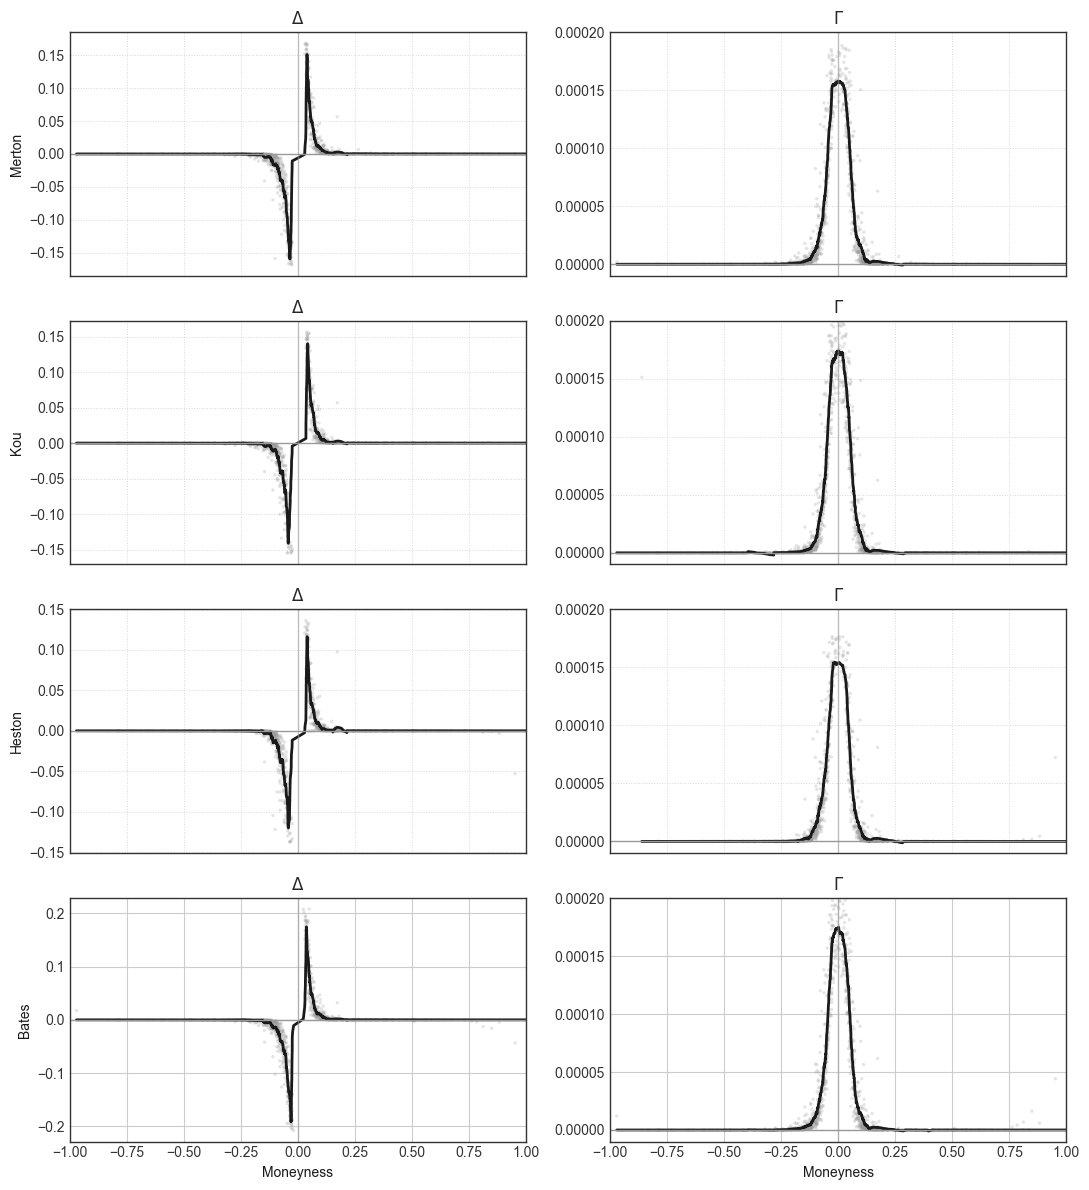

In [ ]:
MODELS   = ["merton","kou","heston","bates"]
DATA_DIR = Path("/Users/joris/Documents/Master QF/Thesis/optimal-gamma-hedging/COS_Pricers/Hedging/")

close_hour = '07'
def smooth_series(y, frac=0.06, poly=3):
    y = np.asarray(y, float)
    n = len(y)
    win = max(5, int(np.ceil(frac * n)) | 1)
    if win >= n:
        return pd.Series(y).rolling(5, center=True, min_periods=1).median().to_numpy()
    return savgol_filter(y, window_length=win, polyorder=min(poly, win-1))

def winsor_mask(y, q=0.005):
    low, high = np.nanquantile(y, [q, 1-q])
    return (y >= low) & (y <= high)

def mad_mask(y, k=8.0):
    med = np.nanmedian(y)
    mad = np.nanmedian(np.abs(y - med)) + 1e-12
    z   = 0.6745 * (y - med) / mad
    return np.abs(z) <= k

def load_model_series(model):
    df = pd.read_csv(DATA_DIR / f"{model}/{model}_hedge_results_08_{close_hour}.csv")
    delta_col = f"delta_{model}" if f"delta_{model}" in df.columns else "delta"
    gamma_col = f"gamma_{model}" if f"gamma_{model}" in df.columns else "gamma"
    use  = df[["moneyness_open", delta_col, gamma_col]].dropna().copy()
    use.sort_values("moneyness_open", inplace=True)

    moneyness = use["moneyness_open"].to_numpy()
    delta = use[delta_col].to_numpy()
    gamma = use[gamma_col].to_numpy()

    # Outlier filters (quantile + MAD, per series)
    mask_delta = winsor_mask(delta, q=0.01) & mad_mask(delta, k=8.0)
    mask_gamma = winsor_mask(gamma, q=0.01) & mad_mask(gamma, k=8.0)

    return moneyness, delta, gamma, mask_delta, mask_gamma

# -------- plotting (grayscale) --------
plt.rcParams.update({
    "axes.edgecolor": "0.2",
    "axes.labelcolor": "0.1",
    "xtick.color": "0.2",
    "ytick.color": "0.2",
})

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(11, 12), sharex=True)
for r, model in enumerate(MODELS):
    moneyness, delta, gamma, mask_delta, mask_gamma = load_model_series(model)

    # smooth on filtered data
    delta_smooth = smooth_series(delta[mask_delta], frac=0.06, poly=2)
    gamma_smooth = smooth_series(gamma[mask_gamma], frac=0.10, poly=2)

    # delta subplot
    ax = axes[r, 0]
    ax.title.set_text(r"$\Delta$")
    ax.scatter(moneyness[mask_delta], delta[mask_delta], s=6, alpha=0.25, color="0.6", edgecolors="none")
    ax.plot(moneyness[mask_delta], delta_smooth, linewidth=2, color="0.1")
    ax.axhline(0, linewidth=1, color="0.6")
    ax.axvline(0, linewidth=1, color="0.6", alpha=0.6)
    ax.set_ylabel(f"{model.capitalize()}")
    if r == 3:
        ax.set_xlabel("Moneyness")

    # gamma subplot
    ax = axes[r, 1]
    ax.title.set_text(r"$\Gamma$")
    ax.scatter(moneyness[mask_gamma], gamma[mask_gamma], s=6, alpha=0.25, color="0.6", edgecolors="none")
    ax.plot(moneyness[mask_gamma], gamma_smooth, linewidth=2, color="0.1")
    ax.set_ylim(-0.00001, 0.00020)
    ax.axhline(0, linewidth=1, color="0.6")
    ax.axvline(0, linewidth=1, color="0.6", alpha=0.6)
    if r == 3: ax.set_xlabel("Moneyness")

for c in range(2):
    for r in range(3):
        ax = axes[r, c]
        ax.grid(True, linestyle=":", linewidth=0.7, color="0.85")
        ax.set_xlim(-1.0, 1.0)   

plt.tight_layout()
plt.show()



Distribution of Quotes Across Moneyness Buckets
                  Count  % of Total Quotes
moneyness_bucket                          
(-inf, -1.00]         4              0.27%
(-1.00, -0.95]        2              0.13%
(-0.95, -0.90]        0              0.00%
(-0.90, -0.85]        3              0.20%
(-0.85, -0.80]        1              0.07%
(-0.80, -0.75]        3              0.20%
(-0.75, -0.70]        4              0.27%
(-0.70, -0.65]        4              0.27%
(-0.65, -0.60]        6              0.40%
(-0.60, -0.55]        4              0.27%
(-0.55, -0.50]        8              0.54%
(-0.50, -0.45]        6              0.40%
(-0.45, -0.40]        6              0.40%
(-0.40, -0.35]        9              0.61%
(-0.35, -0.30]       15              1.01%
(-0.30, -0.25]       30              2.02%
(-0.25, -0.20]       69              4.65%
(-0.20, -0.15]       98              6.60%
(-0.15, -0.10]      140              9.43%
(-0.10, -0.05]      160             10.77%
(-0.0

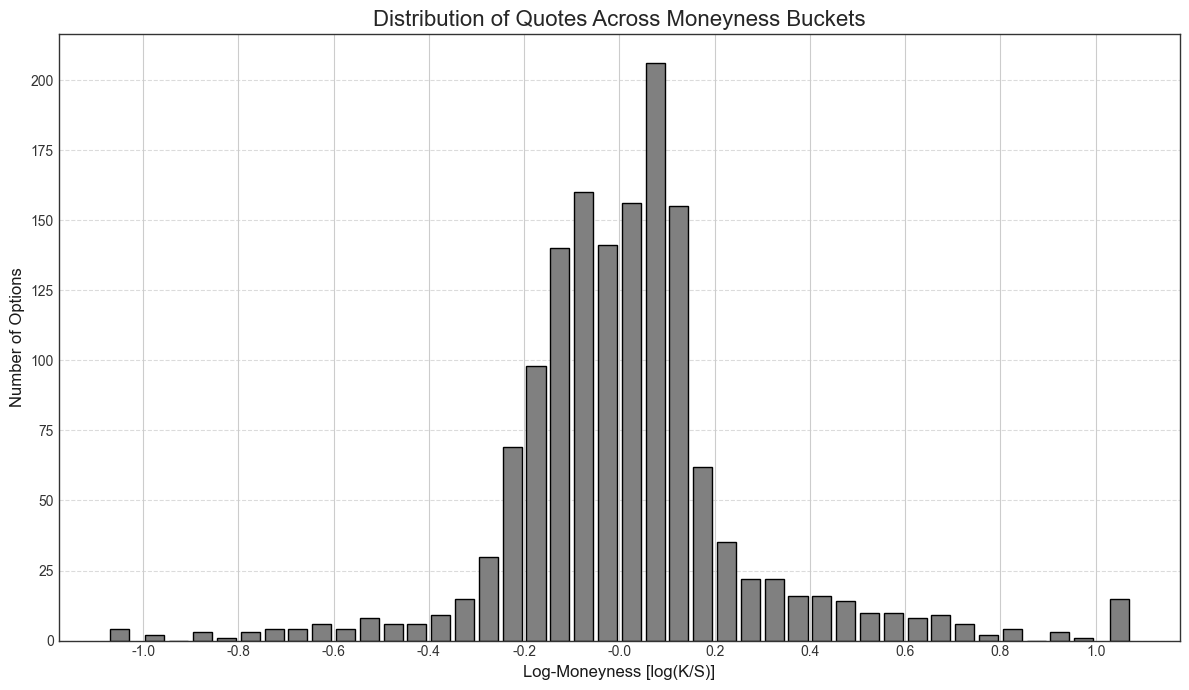

In [ ]:
model = 'merton' 
file_path = f'/Users/joris/Documents/Master QF/Thesis/optimal-gamma-hedging/COS_Pricers/Hedging/{model}/{model}_hedge_results_08_06.csv'
df = pd.read_csv(file_path)

core_bins = np.arange(-1.0, 1.05, 0.05)
bins = np.concatenate(([-np.inf], core_bins, [np.inf]))
labels = []
for i in range(len(bins) - 1):
    if i == 0:
        label = f"(-inf, {bins[i+1]:.2f}]"
    elif i == len(bins) - 2:
        label = f"({bins[i]:.2f}, inf)"
    else:
        label = f"({bins[i]:.2f}, {bins[i+1]:.2f}]"
    labels.append(label)

df['moneyness_bucket'] = pd.cut(df['moneyness_open'], bins=bins, labels=labels, right=True)
bucket_counts = df['moneyness_bucket'].value_counts().sort_index()
total_quotes = len(df)
quote_percentages = (bucket_counts / total_quotes * 100)

results_df = pd.DataFrame({
    'Count': bucket_counts,
    '% of Total Quotes': quote_percentages
})

print("\n" + "="*50)
print("Distribution of Quotes Across Moneyness Buckets")
print("="*50)
print(results_df.to_string(float_format="%.2f%%"))
print("-" * 50)
print(f"Total Quotes Analyzed: {total_quotes}")
print("="*50)


midpoints = (bins[:-1] + bins[1:]) / 2
midpoints[0] = bins[1] - 0.05   
midpoints[-1] = bins[-2] + 0.05 

tick_locations = np.arange(-1.0, 1.1, 0.2)
tick_labels = [f'{tick:.1f}' for tick in tick_locations]

plt.figure(figsize=(12, 7))
plt.bar(midpoints, results_df['Count'].values, width=0.04, color='gray', edgecolor='black')
plt.xticks(tick_locations, tick_labels)
plt.title('Distribution of Quotes Across Moneyness Buckets', fontsize=16)
plt.xlabel('Log-Moneyness [log(K/S)]', fontsize=12)
plt.ylabel('Number of Options', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()